/var/folders/rz/rtszg9fs77sbq8rxtr97cndr0000gn/T/ipykernel_16134/309117378.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data.fillna(method='ffill', inplace=True)
/var/folders/rz/rtszg9fs77sbq8rxtr97cndr0000gn/T/ipykernel_16134/309117378.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data.fillna(method='ffill', inplace=True)


Shape of X_train: (830, 240, 5)
Shape of y_train: (830,)
Shape of X_test: (208, 240, 5)
Shape of y_test: (208,)
Epoch [10/50], Loss: 0.0304
Epoch [20/50], Loss: 0.0109
Epoch [30/50], Loss: 0.0047
Epoch [40/50], Loss: 0.0035
Epoch [50/50], Loss: 0.0025


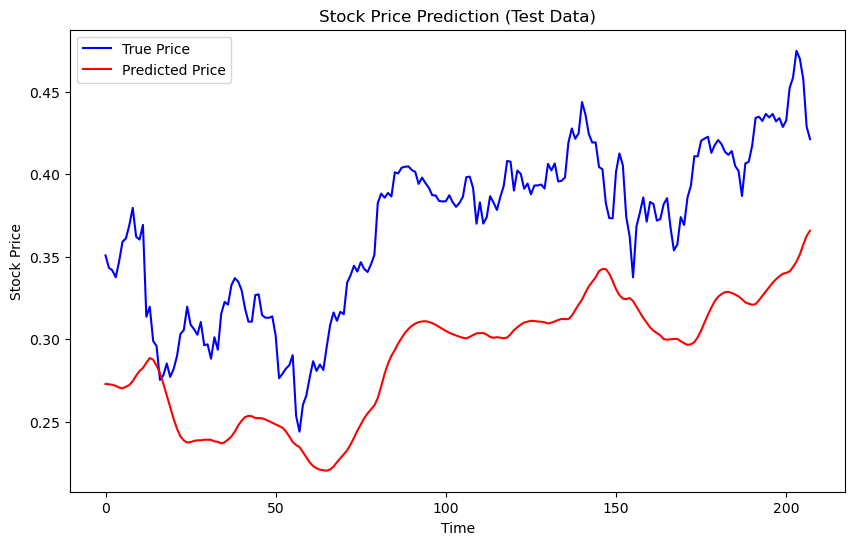

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 加载数据
train_file = "Google_Stock_Price_Train.csv"  # 替换为正确路径
test_file = "Google_Stock_Price_Test.csv"  # 替换为正确路径

# 读取 CSV 文件
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# 数据清理：去掉逗号并转换为 float 类型
def clean_data(data):
    non_numeric_columns = ['Date']  
    for col in data.columns:
        if col not in non_numeric_columns and data[col].dtype == 'object':
            data[col] = data[col].replace({',': ''}, regex=True)
            data[col] = data[col].astype(float)
    return data

train_data = clean_data(train_data)
test_data = clean_data(test_data)

train_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='ffill', inplace=True)

# 去掉日期列并归一化
train_data_values = train_data.drop('Date', axis=1)
test_data_values = test_data.drop('Date', axis=1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data_values)
scaled_test_data = scaler.transform(test_data_values)

# 创建时间序列数据
def create_sequences(data, seq_length=240):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # 'Close' 列
    return np.array(X), np.array(y)

scaled_full_data = np.concatenate((scaled_train_data, scaled_test_data), axis=0)

X_full, y_full = create_sequences(scaled_full_data, seq_length=240)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, shuffle=False)

# 检查数据形状
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# 定义 LSTM 模型，增加隐藏单元数和层数
class StockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])  
        return out

input_dim = X_train.shape[2]  
hidden_dim = 128  
output_dim = 1  
num_layers = 2  

model = StockPredictor(input_dim, hidden_dim, output_dim, num_layers=num_layers, dropout=0.2)

# 损失函数使用 Huber Loss
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 将模型移动到 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor.to(device))

    loss = criterion(outputs, y_train_tensor.to(device))

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:  
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 评估模型
model.eval()
with torch.no_grad():
    predicted = model(X_test_tensor.to(device)).cpu().numpy()
    y_test_actual = y_test_tensor.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='True Price', color='blue')
plt.plot(predicted, label='Predicted Price', color='red')
plt.title('Stock Price Prediction (Test Data)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Shape of X_train: (830, 240, 1)
Shape of y_train: (830,)
Shape of X_test: (208, 240, 1)
Shape of y_test: (208,)
SVR MSE: 6997.6583


/var/folders/rz/rtszg9fs77sbq8rxtr97cndr0000gn/T/ipykernel_16134/3738864901.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data.fillna(method='ffill', inplace=True)
/var/folders/rz/rtszg9fs77sbq8rxtr97cndr0000gn/T/ipykernel_16134/3738864901.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data.fillna(method='ffill', inplace=True)


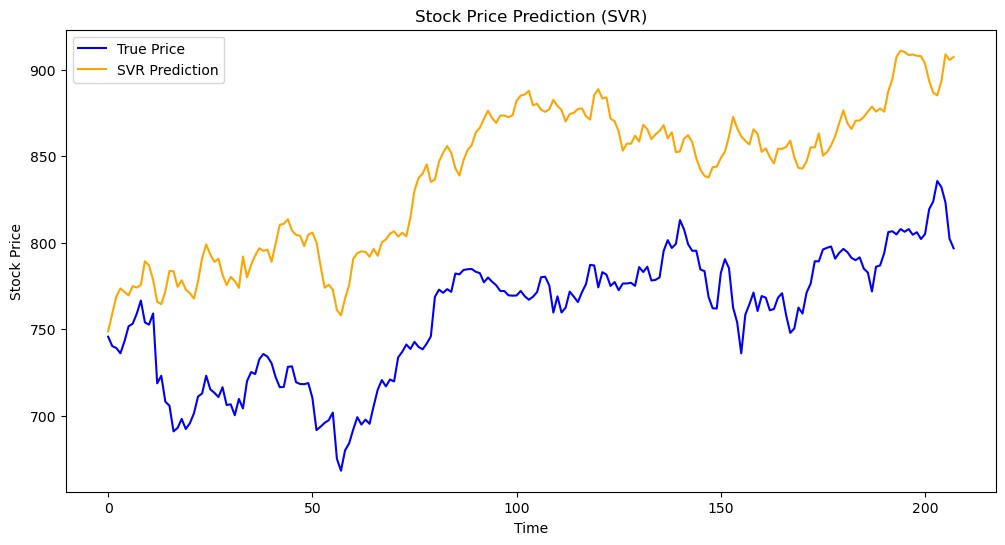

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 加载数据
train_file = "Google_Stock_Price_Train.csv"  # 替换为正确路径
test_file = "Google_Stock_Price_Test.csv"  # 替换为正确路径

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# 数据清理
def clean_data(data):
    non_numeric_columns = ['Date']  # 非数值列
    for col in data.columns:
        if col not in non_numeric_columns and data[col].dtype == 'object':
            data[col] = data[col].replace({',': ''}, regex=True)
            data[col] = data[col].astype(float)
    return data

train_data = clean_data(train_data)
test_data = clean_data(test_data)

train_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='ffill', inplace=True)

# 独立归一化 Close 列
close_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_close = close_scaler.fit_transform(train_data[['Close']])
scaled_test_close = close_scaler.transform(test_data[['Close']])

# 创建时间序列数据
def create_sequences(data, seq_length=240):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # 仅使用 'Close' 列
    return np.array(X), np.array(y)

# 使用 Close 列创建时间序列
scaled_full_close = np.concatenate((scaled_train_close, scaled_test_close), axis=0)
X_full, y_full = create_sequences(scaled_full_close, seq_length=240)

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, shuffle=False)

# 检查数据形状
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# 将多维时间序列数据展平成二维数组以适配SVR
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # [samples, features]
X_test_flat = X_test.reshape(X_test.shape[0], -1)    # [samples, features]

svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)

# 训练SVR模型
svr_model.fit(X_train_flat, y_train)

# 预测测试集
svr_predictions = svr_model.predict(X_test_flat)

# 解归一化预测值和真实值
svr_predictions = close_scaler.inverse_transform(np.array(svr_predictions).reshape(-1, 1)).flatten()
y_test_actual = close_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 计算误差
svr_mse = mean_squared_error(y_test_actual, svr_predictions)
print(f"SVR MSE: {svr_mse:.4f}")

# 绘制结果对比
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='True Price', color='blue')
plt.plot(svr_predictions, label='SVR Prediction', color='orange')
plt.title('Stock Price Prediction (SVR)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
